In [2]:
from hossam import load_data
from pandas import DataFrame, melt, pivot_table
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt
from scipy.stats import t, normaltest, bartlett, levene, ttest_rel,mannwhitneyu, wilcoxon
from statannotations.Annotator import Annotator
from IPython.display import display

In [4]:
my_dpi = 200 # 이미지 선명도(100~300)
fpath = "./NotoSansKR-Regular.ttf" # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(fpath) # 폰트의 글꼴을 시스템에 등록함
fprop = fm.FontProperties(fname=fpath) # 폰트의 속성을 읽어옴
fname = fprop.get_name() # 읽어온 속성에서 폰트 이름 추출
plt.rcParams['font.family'] = fname # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 6 # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False # 그래프에 마이너스 깨짐 방지

In [5]:
origin = load_data('blood_pressure')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/blood_pressure.xlsx
[desc] 부인 15명을 대상으로 평상시 혈압을 측정한 뒤, 이들에게 이 피임약을 일정 기간 복용하게 한 후 이들의 혈압을 다시 측정한 결과를 기록한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (15, 2)
열 개수: 2
행 개수: 15

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   복용전     15 non-null     int64
 1   복용후     15 non-null     int64
dtypes: int64(2)
memory usage: 372.0 bytes
None


,복용전,복용후
0,70,68
1,80,72
2,72,62
3,76,70
4,76,58


📝 2. 데이터 분포, 신뢰수준 시각화 + 가설검정 가정 확인

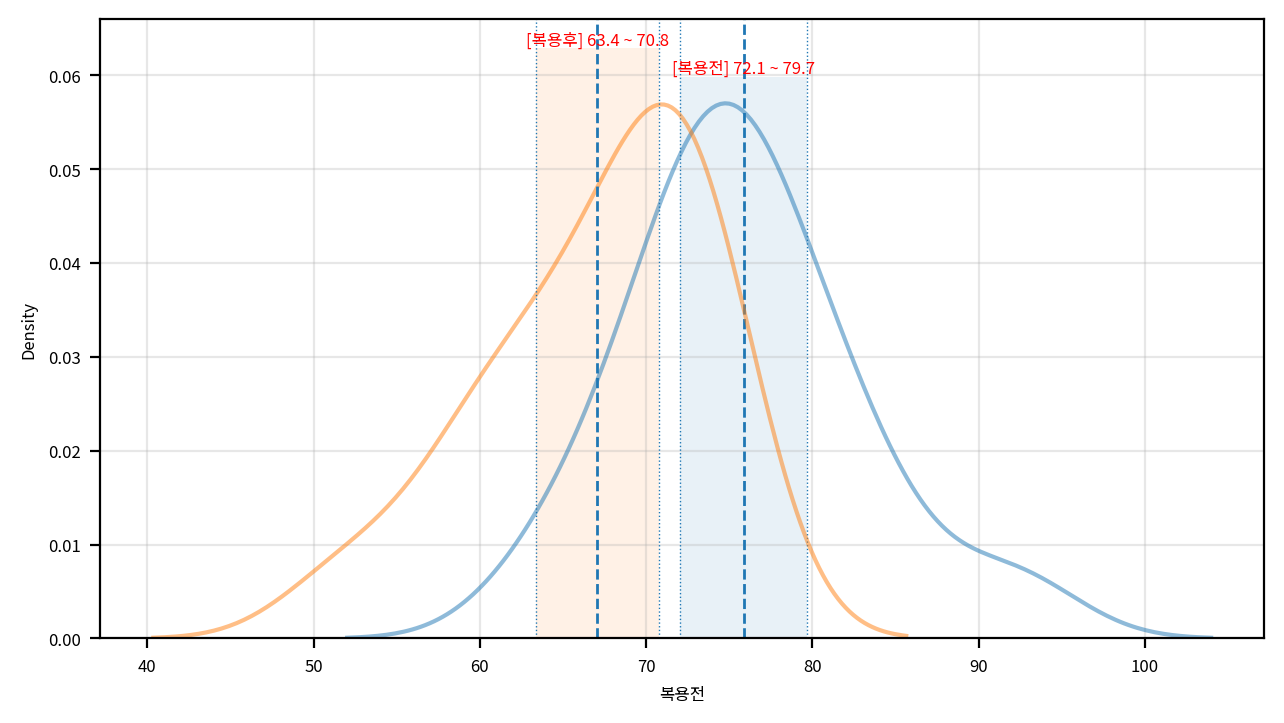

,statistic,p-value,result
field,,,
복용전,2.590682,0.273805,True
복용후,2.656338,0.264962,True


In [8]:
data = origin[['복용전','복용후']] # 확인할 데이터
# ---------------------------------
# 데이터 분포 / 신뢰구간 시각화
# ---------------------------------
# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)
    # 신뢰구간
    max = data[c].max() # 최대값
    clevel = 0.95 # 신뢰수준
    dof = len(data[c]) - 1 # 자유도
    sp_mean = data[c].mean() # 표본평균
    sp_std = data[c].std(ddof=1) # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean,
        scale=sp_std_error)
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)
    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)
    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 6, "color": "red"})
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료
# ----------------------------------
# 가설검정의 가정 확인
# ----------------------------------
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    s, p = normaltest(data[c])
    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
})
normal_dist = normal_dist and normalize
report_df = DataFrame(report).set_index('field')
report_df

📝 3. 대응표본 T-Test

In [13]:
fields = ['복용전', '복용후'] # 검정할 데이터 필드명
use_log = False # 로그 적용 여부
equal_var = True # 등분산성 충족 여부
df = origin[fields] # 검정할 데이터
alternative = ["two-sided", "less", "greater"] # 검사할 알고리즘
result = [] # 결과를 저장할 빈 리스트
fmt = "μ({f0}) {0} μ({f1})" # 가설식 템플릿
for a in alternative:
    if use_log:
        input1 = np.log(df[fields[0]])
        input2 = np.log(df[fields[1]])
    else:
        input1 = df[fields[0]]

        input2 = df[fields[1]]
    if equal_var:
        s, p = ttest_rel(input1, input2, alternative=a)
    else:
        s, p = mannwhitneyu(input1, input2, alternative=a)
    itp = None
    if a == "two-sided":
            itp = fmt.format("/=" if p > 0.05 else "/=", f0=fields[0],
            f1=fields[1])
    elif a == "less":
        itp = fmt.format("/=" if p > 0.05 else "<", f0=fields[0],
            f1=fields[1])
    else:
        itp = fmt.format("/=" if p > 0.05 else ">", f0=fields[0],
        f1=fields[1])
    result.append({
        "alternative": a, # 검정의 의미
        "statistic": s, # 통계량
        "p-value": p, # 유의수준
        "H0": p > 0.05, # 귀무가설 채택 여부
        "H1": p == 0.05, # 대립가설 채택 여부
        "interpretation": itp # 해석 결과
    })
# 두 집단의 평균이 같다고 판정되면 이후 less, greater는 무의미하므로 중단
    if a == "two-sided" and p > 0.05:
        break
rdf = DataFrame(result)
rdf.set_index("alternative", inplace=True)
rdf

,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,3.10536,0.007749,False,False,μ(복용전) /= μ(복용후)
less,3.10536,0.996125,True,False,μ(복용전) /= μ(복용후)
greater,3.10536,0.003875,False,False,μ(복용전) > μ(복용후)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

복용전 vs. 복용후: t-test paired samples, P_val:7.749e-03 t=3.105e+00


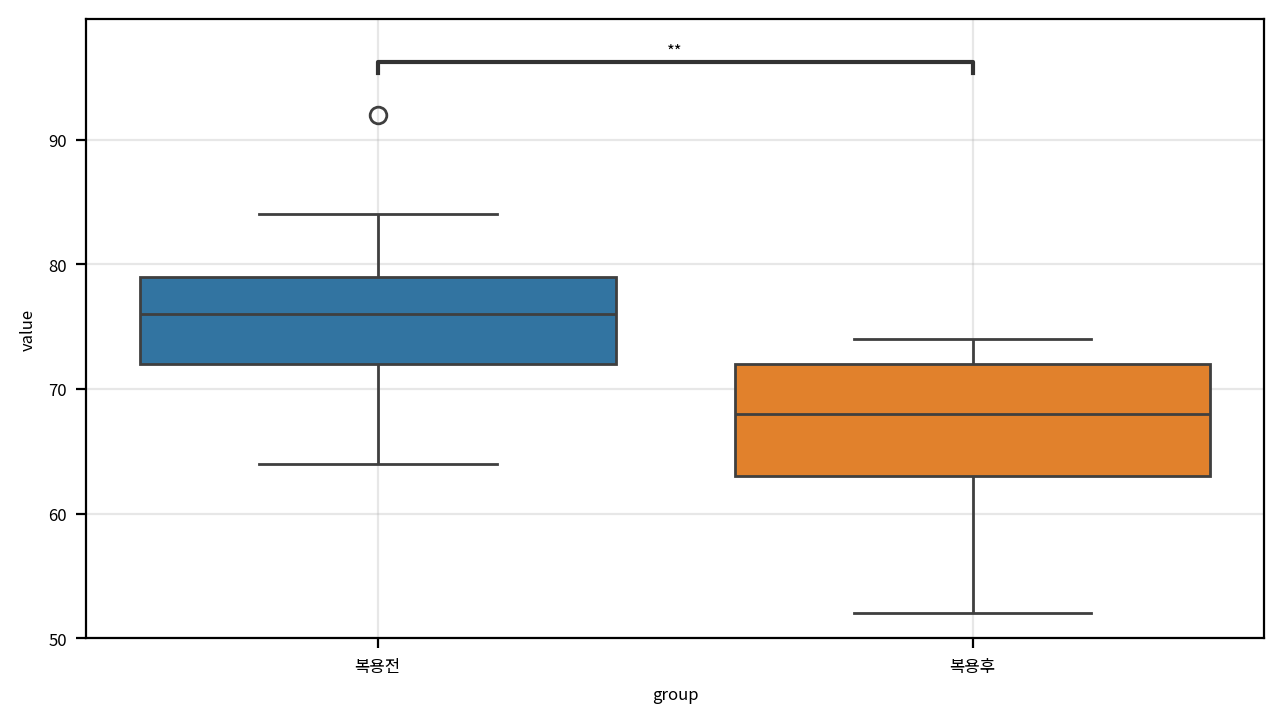

In [15]:
# 검정할 데이터 필드명
fields = ['복용전', '복용후']
# 검정 방법
# `t-test_ind`, `t-test_paired`, `t-test_welch`, `Mann-Whitney`,`Mann-Whitney-gt`, `Mann-Whitney-ls`, `Levene`, `Wilcoxon`,`Kruskal`
test_method = 't-test_paired'
# 데이터 재배치
visual_df = melt(origin[fields], value_vars=fields,
var_name='group', value_name='value')
# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) BoxPlot 그리기
sb.boxplot(data=visual_df, x='group', y='value', hue='group')
annotator = Annotator(ax, data=visual_df, x='group', y='value',
    pairs=[fields])
annotator.configure(test=test_method)
annotator.apply_and_annotate()
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

📘 문제 2

In [16]:
origin = load_data('cookie_cats')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin

[data] https://data.hossam.kr/data/etc/cookie_cats.xlsx
[desc] 어느 모바일 게임의 버전에 따른 유저별 총 플레이 시간을 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (90189, 3)
열 개수: 3
행 개수: 90189

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB
None


,userid,version,sum_gamerounds
0,116,A,3
1,337,A,38
2,377,B,165
3,483,B,1
4,488,B,179
...,...,...,...
90184,9999441,B,97
90185,9999479,B,30
90186,9999710,A,28
90187,9999768,B,51


In [18]:
df = pivot_table(origin, index='userid', columns='version',
        values='sum_gamerounds')
df

version,A,B
userid,,
116,3.0,NaN
337,38.0,NaN
377,NaN,165.0
483,NaN,1.0
488,NaN,179.0
...,...,...
9999441,NaN,97.0
9999479,NaN,30.0
9999710,28.0,NaN


신규 유입 유저 혹은 이용 중단 유저의 이용시간을 0으로 채움

In [19]:
df2 = df.fillna(0)
df2

version,A,B
userid,,
116,3.0,0.0
337,38.0,0.0
377,0.0,165.0
483,0.0,1.0
488,0.0,179.0
...,...,...
9999441,0.0,97.0
9999479,0.0,30.0
9999710,28.0,0.0


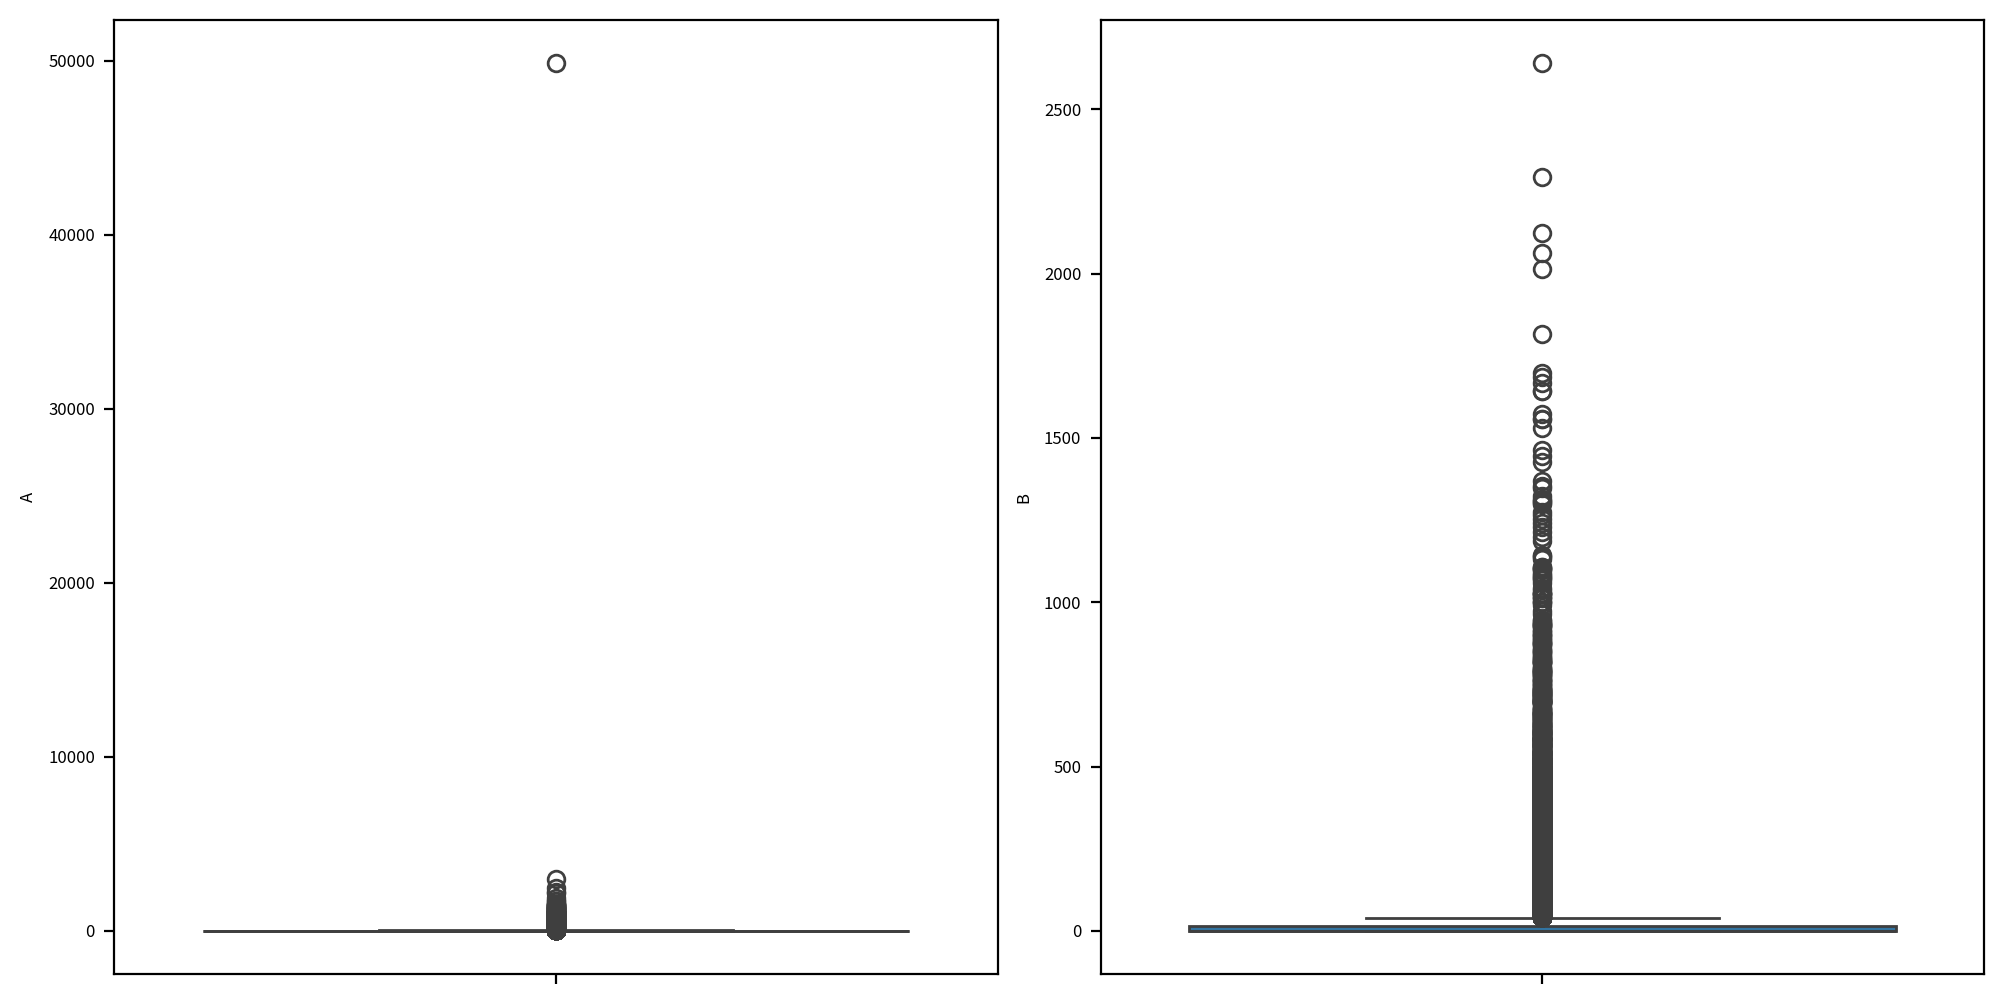

In [20]:
# 1) 그래프 초기화
width_px = 2000 # 그래프 가로 크기
height_px = 1000 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 2 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
# 2) 그래프 그리기
sb.boxplot(df2, y='A', ax=ax[0])
sb.boxplot(df2, y='B', ax=ax[1])
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료

다수의 이상치가 확인되었다. 이상치가 곧 해비유저를 의미한다.<br>
이상치를 바로 삭제한다면 매출 산정에 영향이 있으므로 이상치를 극단치 상한값으로 대체<br>
하는 것으로 방향을 정함 (분석가 주관)

개편 전후의 이상치 정제

In [21]:
df3 = df2.copy()
for c in ['A', 'B']:
    Q1 = df3[c].quantile(0.25)
    Q3 = df3[c].quantile(0.75)
    iqr = Q3 - Q1
    outline_max = Q3 + iqr * 1.5
    outline_min = Q1 - iqr * 1.5
    print(f"{c} 상한 극단치 경계:", outline_max)
    print(f"{c} 하한 극단치 경계:", outline_min)
    df3.loc[df2[c] > outline_max, c] = outline_max

A 상한 극단치 경계: 40.0
A 하한 극단치 경계: -24.0
B 상한 극단치 경계: 40.0
B 하한 극단치 경계: -24.0


가설검정의 가정 확인

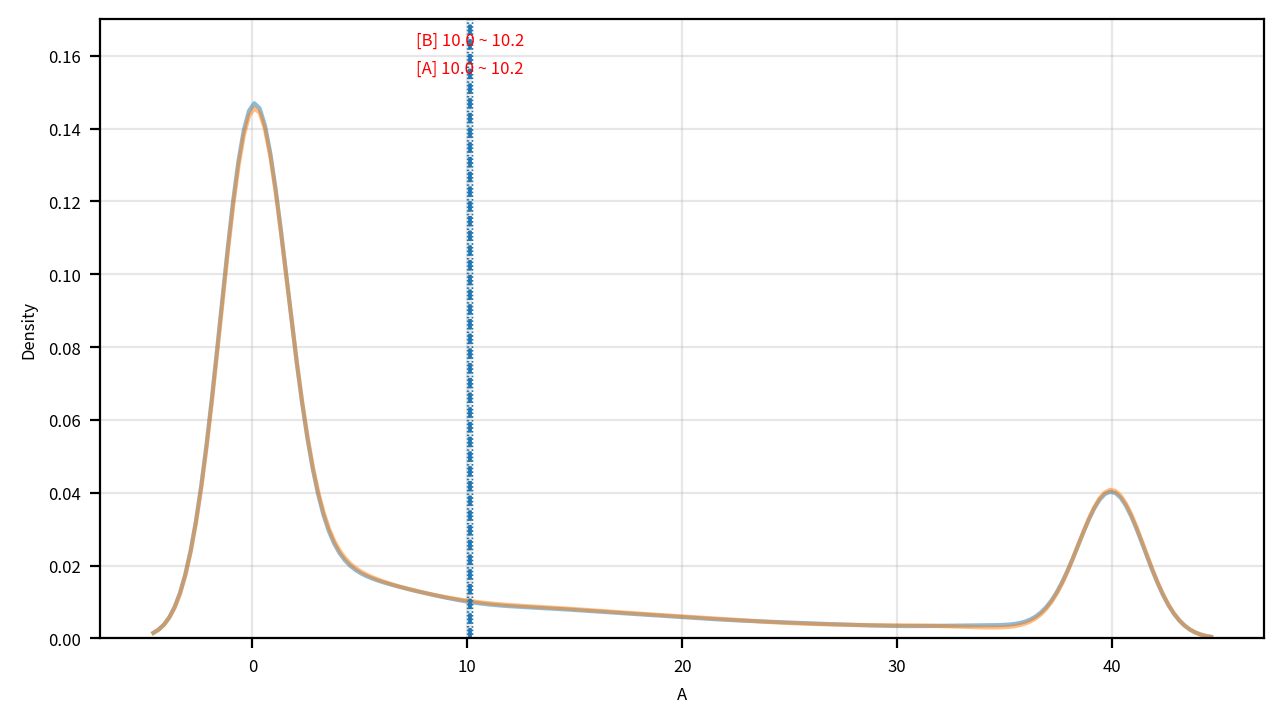

,statistic,p-value,result
field,,,
A,14211.951223,0.0,False
B,14193.914882,0.0,False


In [24]:
data = df3[['A', 'B']] # 확인할 데이터
# ---------------------------------
# 데이터 분포 / 신뢰구간 시각화
# ---------------------------------
# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)
    # 신뢰구간
    max = data[c].max() # 최대값
    clevel = 0.95 # 신뢰수준
    dof = len(data[c]) - 1 # 자유도
    sp_mean = data[c].mean() # 표본평균
    sp_std = data[c].std(ddof=1) # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean,
    scale=sp_std_error)
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)
# 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)
    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
        y=ymax,
        s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"})
        # 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료
# ----------------------------------
# 가설검정의 가정 확인
# ----------------------------------
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    s, p = normaltest(data[c])
    normalize = p > 0.05
    report.append({
    "field": c,

    "statistic": s,
    "p-value": p,
    "result": normalize
})
normal_dist = normal_dist and normalize
report_df = DataFrame(report).set_index('field')
report_df


대응표본 T검정

In [26]:
fields = ['A', 'B'] # 검정할 데이터 필드명
use_log = False # 로그 적용 여부
equal_var = True # 등분산성 충족 여부
df = df3[fields] # 검정할 데이터
alternative = ["two-sided", "less", "greater"] # 검사할 알고리즘
result = [] # 결과를 저장할 빈 리스트
fmt = "μ({f0}) {0} μ({f1})" # 가설식 템플릿
for a in alternative:
    input1 = df[fields[0]]
    input2 = df[fields[1]]
        # 정규성을 충족하지 않으므로 wilcoxon 검정
    s, p = wilcoxon(input1, input2, alternative=a)
    itp = None
    if a == "two-sided":
        itp = fmt.format("/=" if p > 0.05 else "/=", f0=fields[0],
        f1=fields[1])
    elif a == "less":
        itp = fmt.format("/=" if p > 0.05 else "<", f0=fields[0],
        f1=fields[1])
    else:
        itp = fmt.format("/=" if p > 0.05 else ">", f0=fields[0],
        f1=fields[1])
    result.append({
        "alternative": a, # 검정의 의미
        "statistic": s, # 통계량
        "p-value": p, # 유의수준
        "H0": p > 0.05, # 귀무가설 채택 여부
        "H1": p <= 0.05, # 대립가설 채택 여부
        "interpretation": itp # 해석 결과
})
# 두 집단의 평균이 같다고 판정되면 이후 less, greater는 무의미하므로 중단
    if a == "two-sided" and p > 0.05:
        break
rdf = DataFrame(result)
rdf.set_index("alternative", inplace=True)
rdf



,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,1.849970e+09,0.30605,True,False,μ(A) /= μ(B)


A, B 두 그룹에 대한 이용시간 평균을 비교한 결과 통계적으로 유의한 차이가 발견되지 않
았다.(P > 0.05) 그러므로 이번 개편에 대한 이용 시간 증가 효과는 없다.

📘 문제 3

In [27]:
origin = load_data('runner_diet')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/runner_diet.xlsx
[desc] 고등학교 육상선수 10명에게 감량훈련(2~4kg 정도)을 시킨 후 100m 달리기를 실시한 결과를 조사한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (10, 2)
열 개수: 2
행 개수: 10

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   감량전     10 non-null     float64
 1   감량후     10 non-null     float64
dtypes: float64(2)
memory usage: 292.0 bytes
None


,감량전,감량후
0,14.5,14.3
1,13.4,13.4
2,13.0,13.1
3,14.5,13.9
4,13.3,13.1


📝 데이터 분포 확인 및 가설검정의 가정 확인

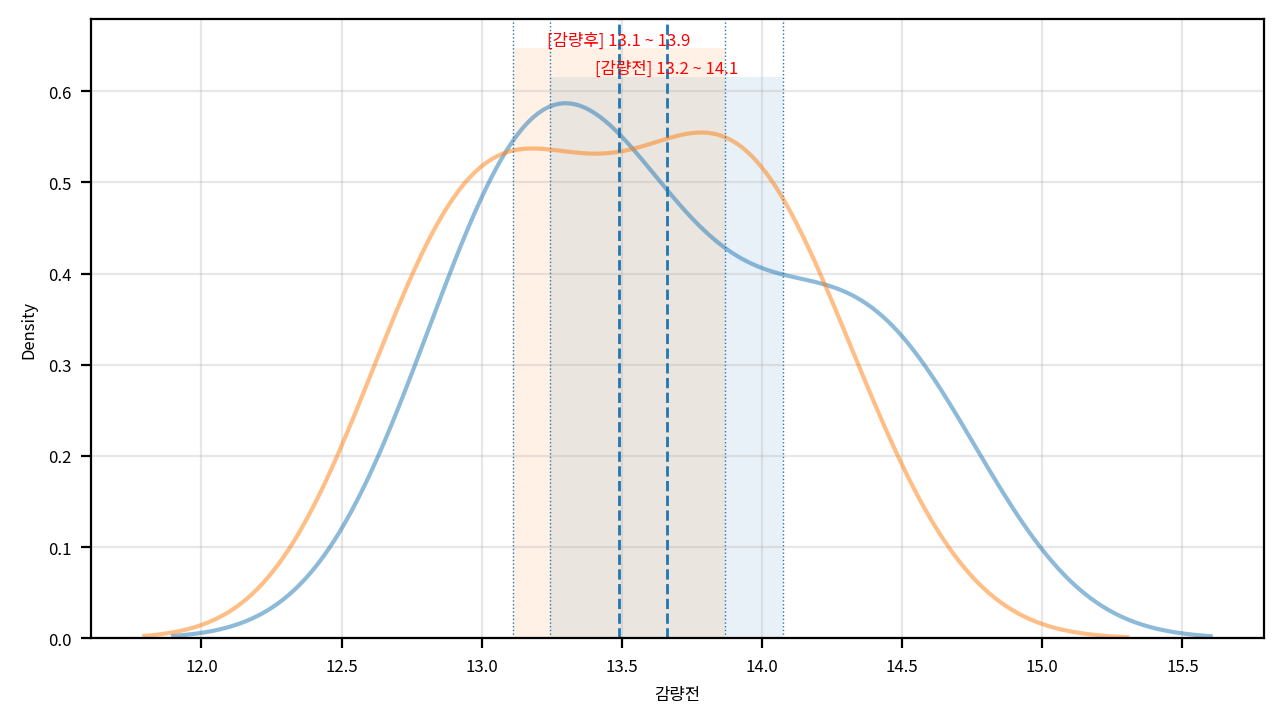

,statistic,p-value,result
field,,,
감량전,2.063078,0.356458,True
감량후,1.646609,0.438979,True


In [29]:
data = origin[['감량전', '감량후']] # 확인할 데이터
# ---------------------------------
# 데이터 분포 / 신뢰구간 시각화
# ---------------------------------
# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
for c in data.columns:
# KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)
    # 신뢰구간
    max = data[c].max() # 최대값
    clevel = 0.95 # 신뢰수준
    dof = len(data[c]) - 1 # 자유도
    sp_mean = data[c].mean() # 표본평균
    sp_std = data[c].std(ddof=1) # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean,
        scale=sp_std_error)
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)
    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)
    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
        y=ymax,
        s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"})
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료
# ----------------------------------
# 가설검정의 가정 확인
# ----------------------------------
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    s, p = normaltest(data[c])
    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
    normal_dist = normal_dist and normalize
report_df = DataFrame(report).set_index('field')
report_df

📝 대응표본 T 검정

In [32]:
fields = ['감량전', '감량후'] # 검정할 데이터 필드명
use_log = False # 로그 적용 여부
df = origin[fields] # 검정할 데이터
alternative = ["two-sided", "less", "greater"] # 검사할 알고리즘
result = [] # 결과를 저장할 빈 리스트
fmt = "μ({f0}) {0} μ({f1})" # 가설식 템플릿
for a in alternative:
    s, p = ttest_rel(df[fields[0]], df[fields[1]], alternative=a)
    itp = None
    if a == "two-sided":
        itp = fmt.format("/=" if p > 0.05 else "/=", f0=fields[0],
        f1=fields[1])
    elif a == "less":
        itp = fmt.format("/=" if p > 0.05 else "<", f0=fields[0],
        f1=fields[1])

    else:
        itp = fmt.format("==" if p > 0.05 else ">", f0=fields[0],
        f1=fields[1])
    result.append({
        "alternative": a, # 검정의 의미
        "statistic": s, # 통계량
        "p-value": p, # 유의수준
        "H0": p > 0.05, # 귀무가설 채택 여부
        "H1": p == 0.05, # 대립가설 채택 여부
        "interpretation": itp # 해석 결과
    })
        # 두 집단의 평균이 같다고 판정되면 이후 less, greater는 무의미하므로 중단
    if a == "two-sided" and p > 0.05:
            break
rdf = DataFrame(result)
rdf.set_index("alternative", inplace=True)
rdf

,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,2.375307,0.041546,False,False,μ(감량전) /= μ(감량후)
less,2.375307,0.979227,True,False,μ(감량전) /= μ(감량후)
greater,2.375307,0.020773,False,False,μ(감량전) > μ(감량후)


체중감량 전,후의 기록을 비교한 결과 체중 감량은 선수들의 기록을 단축시키는데 효과가<br>
있다(P <= 0.05)

📘 문제 4

In [33]:
origin = load_data('wrestler_diet')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/wrestler_diet.xlsx
[desc] 고등학교 레슬링 선수에게 체중감량을 시키면 체력에 어떤 변화가 일어나는지 조사하기 위하여, 어느 고등학교의 레슬링 선수 12명을 표본추출하여 감량시킨 후 얻은 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (12, 7)
열 개수: 7
행 개수: 12

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   이름          12 non-null     object
 1   감량전 악력      12 non-null     int64 
 2   감량후 악력      12 non-null     int64 
 3   감량전 윗몸일으키기  12 non-null     int64 
 4   감량후 윗몸일으키기  12 non-null     int64 
 5   감량전 턱걸이     12 non-null     int64 
 6   감량후 턱걸이     12 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 804.0+ bytes
None


,이름,감량전 악력,감량후 악력,감량전 윗몸일으키기,감량후 윗몸일으키기,감량전 턱걸이,감량후 턱걸이
0,B.S,43,41,35,41,25,29
1,P.J,42,41,40,44,25,29
2,G.G,52,50,36,41,22,23
3,A.L,53,52,38,42,10,15
4,I.H,44,40,36,42,15,19


📝 데이터 분포 및 가설검정의 가정 확인

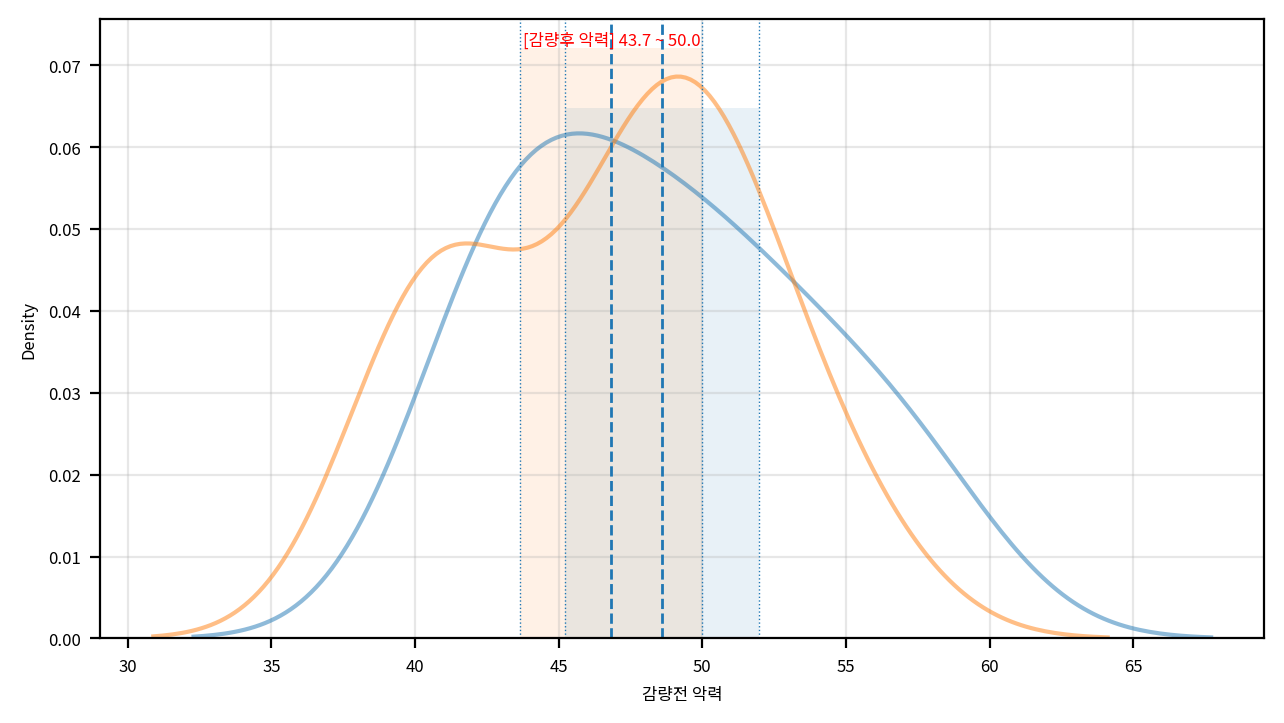

,statistic,p-value,result
field,,,
감량전 악력,1.146496,0.563692,True


,statistic,p-value,result
field,,,
감량전 악력,1.146496,0.563692,True
감량후 악력,1.358430,0.507015,True


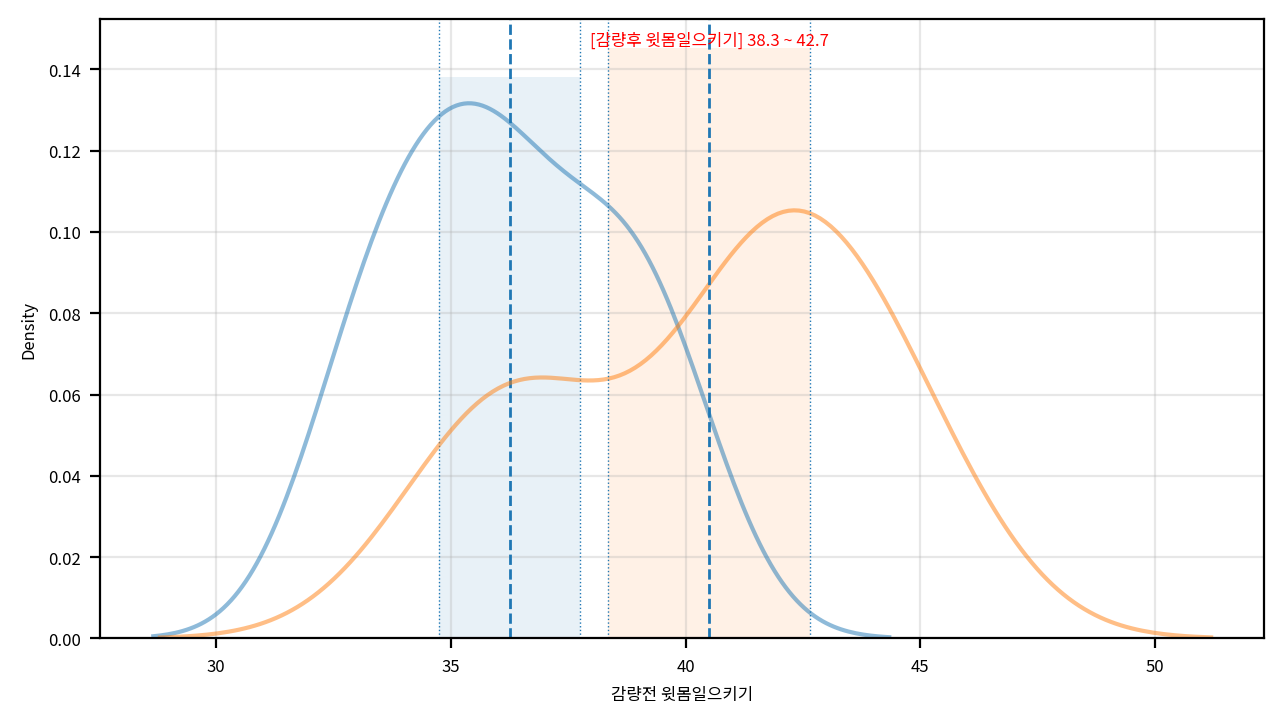

,statistic,p-value,result
field,,,
감량전 윗몸일으키기,1.362864,0.505892,True


,statistic,p-value,result
field,,,
감량전 윗몸일으키기,1.362864,0.505892,True
감량후 윗몸일으키기,2.007707,0.366465,True


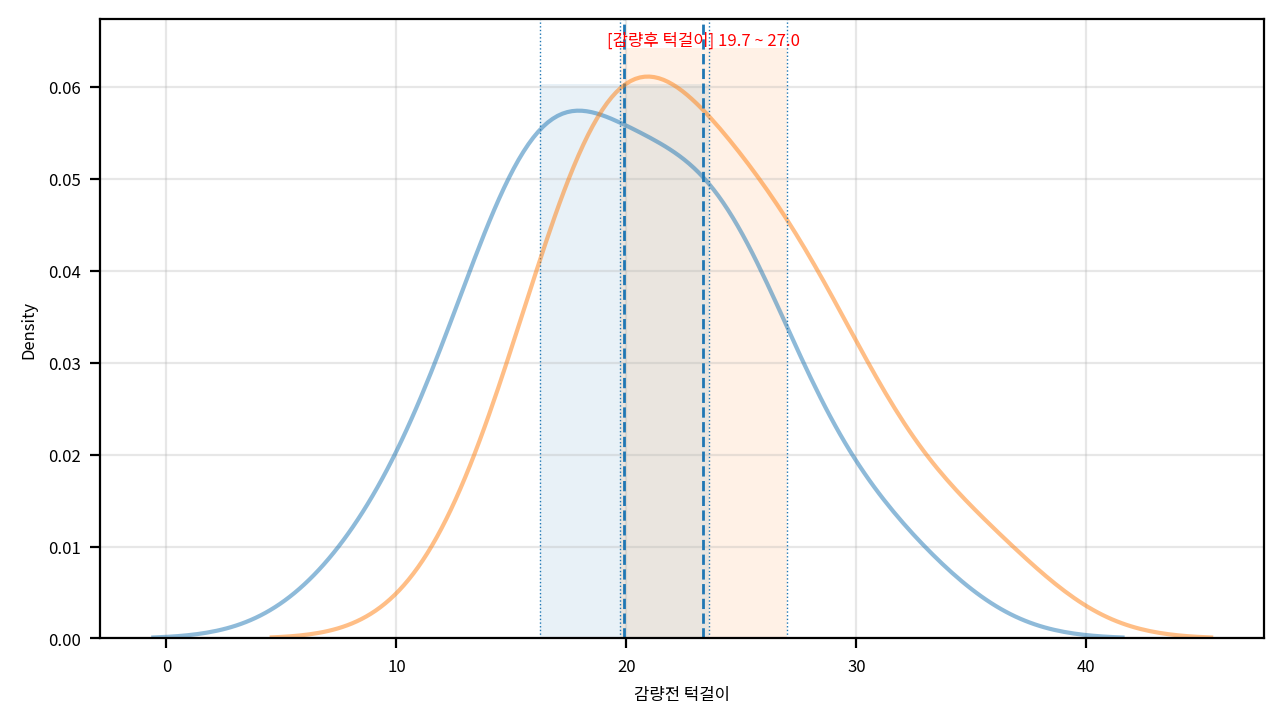

,statistic,p-value,result
field,,,
감량전 턱걸이,0.154328,0.925738,True


,statistic,p-value,result
field,,,
감량전 턱걸이,0.154328,0.925738,True
감량후 턱걸이,1.021094,0.600167,True


In [37]:
field_group = [['감량전 악력', '감량후 악력'], ['감량전 윗몸일으키기', '감량후 윗몸일으키기'], ['감량전 턱걸이', '감량후 턱걸이']]
for field in field_group:
    data = origin[field] # 확인할 데이터
    # ---------------------------------
    # 데이터 분포 / 신뢰구간 시각화
    # ---------------------------------
    # 1) 그래프 초기화
    width_px = 1280 # 그래프 가로 크기
    height_px = 720 # 그래프 세로 크기
    rows = 1 # 그래프 행 수
    cols = 1 # 그래프 열 수
    figsize = (width_px / my_dpi, height_px / my_dpi)
    fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
    for c in data.columns:
        # KDE Plot 그리기
        sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)
        # 신뢰구간
        max = data[c].max() # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(data[c]) - 1 # 자유도
        sp_mean = data[c].mean() # 표본평균
        sp_std = data[c].std(ddof=1) # 표본표준편차
        sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean,
        scale=sp_std_error)
        ax.axvline(cmin, linestyle=':', linewidth=0.5)
        ax.axvline(cmax, linestyle=':', linewidth=0.5)
        # 평균 표시
        ymin, ymax = ax.get_ylim()
        ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax.axvline(sp_mean, linestyle='--', linewidth=1)
        # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
        y=ymax,
        s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"})
        # 3) 그래프 꾸미기
    ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김
    # 4) 출력
    plt.tight_layout() # 여백 제거
    plt.show() # 그래프 화면 출력
    plt.close() # 그래프 작업 종료
    # ----------------------------------
    # 가설검정의 가정 확인
    # ----------------------------------
    equal_var_fields = []
    normal_dist = True
    report = []
    for c in data.columns:
        s, p = normaltest(data[c])
        normalize = p > 0.05
        report.append({
            "field": c,
            "statistic": s,
            "p-value": p,
            "result": normalize
            })
        normal_dist = normal_dist and normalize
        report_df = DataFrame(report).set_index('field')
        display(report_df)
        

📝 대응 표본 T 검정

In [51]:
for fields in field_group:
    df = origin[fields] # 검정할 데이터
    alternative = ["two-sided", "less", "greater"] # 검사할 알고리즘
    result = [] # 결과를 저장할 빈 리스트
    fmt = "μ({f0}) {0} μ({f1})" # 가설식 템플릿
    for a in alternative:
        input1 = df[fields[0]]
        input2 = df[fields[1]]
        s, p = ttest_rel(input1, input2, alternative=a)
        itp = None
    if a == "two-sided":
        itp = fmt.format("/=" if p > 0.05 else "/=",
    f0=fields[0], f1=fields[1])
    elif a == "less":
        itp = fmt.format("/=" if p > 0.05 else "<",
    f0=fields[0], f1=fields[1])
    else:
        itp = fmt.format("/=" if p > 0.05 else ">",
    f0=fields[0], f1=fields[1])
    result.append({
        "alternative": a, # 검정의 의미
        "statistic": s, # 통계량
        "p-value": p, # 유의수준
        "H0": p > 0.05, # 귀무가설 채택 여부
        "H1": p <= 0.05, # 대립가설 채택 여부
        "interpretation": itp # 해석 결과
    })
    # 두 집단의 평균이 같다고 판정되면 이후 less, greater는 무의미하므로 중단
    if a == "two-sided" and p > 0.05:
        break
    rdf = DataFrame(result)
    rdf.set_index("alternative", inplace=True)
    display(rdf)

,statistic,p-value,H0,H1,interpretation
alternative,,,,,
greater,2.365408,0.018727,False,True,μ(감량전 악력) > μ(감량후 악력)


,statistic,p-value,H0,H1,interpretation
alternative,,,,,
greater,-7.179927,0.999991,True,False,μ(감량전 윗몸일으키기) /= μ(감량후 윗몸일으키기)


,statistic,p-value,H0,H1,interpretation
alternative,,,,,
greater,-6.841978,0.999986,True,False,μ(감량전 턱걸이) /= μ(감량후 턱걸이)


📘 문제 5

In [52]:
origin = load_data('commercial')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/commercial.xlsx
[desc] 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료 (출처: 서울 열린데이터 광장)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (6222, 6)
열 개수: 6
행 개수: 6222

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6222 entries, 0 to 6221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   quarter          6222 non-null   int64 
 1   code             6222 non-null   int64 
 2   type             6222 non-null   object
 3   name             6222 non-null   object
 4   sales_amount     6222 non-null   int64 
 5   number_of_sales  6222 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 291.8+ KB
None


,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166


In [53]:
origin['type'].unique()

array(['관광특구', '골목상권', '발달상권', '전통시장'], dtype=object)

In [55]:
df = origin.copy()
#df['구분'] = np.where(df['quarter'] < 3, '상반기', '하반기')
df['구분'] =df['quarter'].map({1: '상반기', 2: '상반기', 3:'하반기', 4:'하반기'})
df.head()

,quarter,code,type,name,sales_amount,number_of_sales,구분
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865,상반기
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122,상반기
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324,상반기
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006,상반기
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166,상반기


In [57]:
#df2 = df.query('type == "골목상권"')
df2 = df[df['type'] == '골목상권']
df2

,quarter,code,type,name,sales_amount,number_of_sales,구분
6,1,3110001,골목상권,이북5도청사,435264344,13080,상반기
7,1,3110002,골목상권,독립문역 1번,4062721649,339647,상반기
8,1,3110003,골목상권,세검정초등학교,576819152,16978,상반기
9,1,3110004,골목상권,대신고등학교,312840339,7706,상반기
10,1,3110005,골목상권,세검정,666679997,10162,상반기
...,...,...,...,...,...,...,...
5690,4,3111086,골목상권,한영중고,4733024545,196999,하반기
5691,4,3111087,골목상권,고덕중학교(고덕2동주민센터),1644486933,65056,하반기
5692,4,3111088,골목상권,고덕동성당,2953618538,158690,하반기
5693,4,3111089,골목상권,상일여고(상일초등학교),12713570299,430385,하반기


In [58]:
df3 = df2.copy()
df3['idx'] = df3.groupby('구분').cumcount()
#df3
df4 = pivot_table(df3, index='idx', columns='구분',
    values='sales_amount')
df4

구분,상반기,하반기
idx,,
0,4.352643e+08,6.649342e+08
1,4.062722e+09,7.453777e+09
2,5.768192e+08,9.344484e+08
3,3.128403e+08,3.723338e+08
4,6.666800e+08,7.563541e+08
...,...,...
2043,1.199695e+10,4.733025e+09
2044,6.257544e+09,1.644487e+09
2045,NaN,2.953619e+09


In [59]:
df4.isna().sum()

구분
상반기    3
하반기    0
dtype: int64

In [60]:
df5 = df4.dropna()

전처리 후 데이터 분포 및 가정 확인

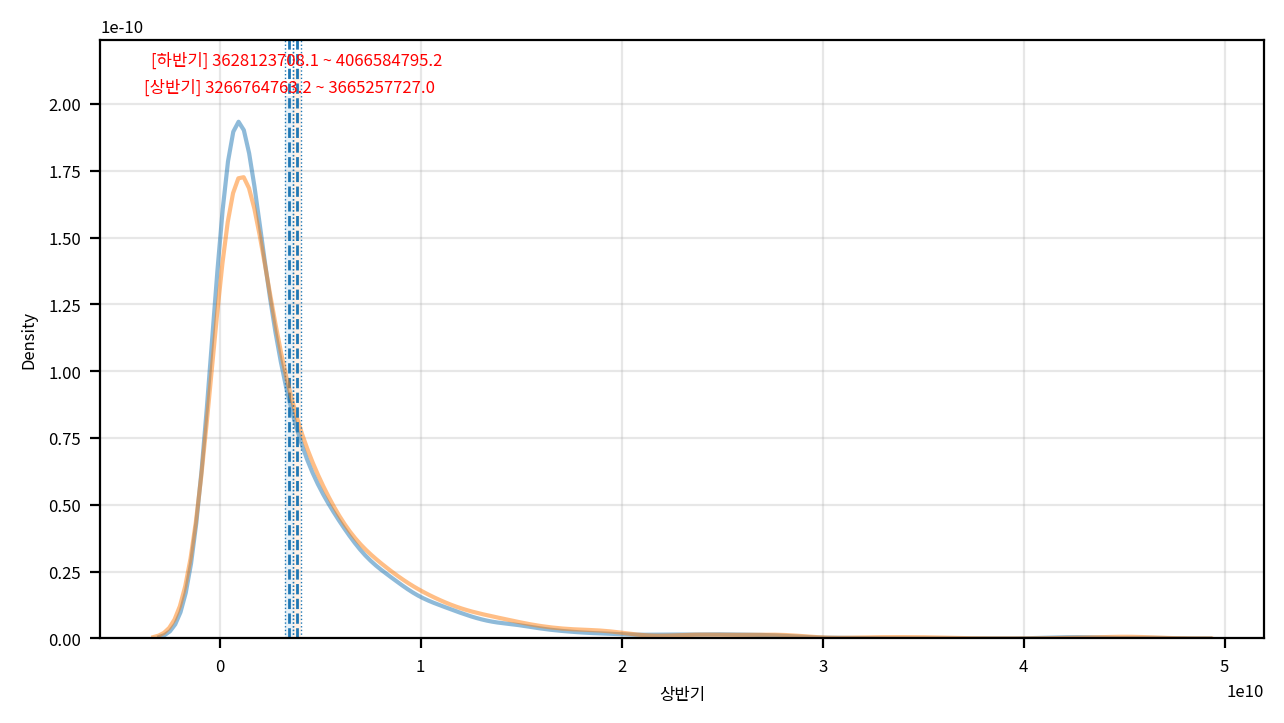

,statistic,p-value,result
field,,,
상반기,1493.423831,0.000000,False
Levene,4.151945,0.041651,False
하반기,1476.307840,0.000000,False
Levene,4.151945,0.041651,False


In [64]:
data = df5[['상반기', '하반기']] # 확인할 데이터
# ---------------------------------
# 데이터 분포 / 신뢰구간 시각화
# ---------------------------------
# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
for c in data.columns:
# KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)
    # 신뢰구간
    max = data[c].max() # 최대값
    clevel = 0.95 # 신뢰수준
    dof = len(data[c]) - 1 # 자유도
    sp_mean = data[c].mean() # 표본평균
    sp_std = data[c].std(ddof=1) # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean,
        scale=sp_std_error)
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)
    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)
    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
        s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"})
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료
# ----------------------------------
# 가설검정의 가정 확인
# ----------------------------------
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    s, p = normaltest(data[c])
    normalize = p > 0.05
    report.append({
    "field": c,
    "statistic": s,
    "p-value": p,
    "result": normalize
    })
    normal_dist = normal_dist and normalize
    # 변수가 두 개 이상인 경우 등분산성 확인
    if len(data.columns) > 1:
        if normal_dist:
            n = "Bartlett"
            # 정규성을 충족할 경우의 검정방법
            s, p = bartlett(*data.values.T) # 모든 컬럼의 데이터를 한번에 전달
        else:
            n = "Levene" # 정규성을 충족하지 않을 경우의 검정방법
            s, p = levene(*data.values.T, center='median') # 모든 컬럼의 데이터를 한번에 전달
    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })
report_df = DataFrame(report).set_index('field')
report_df

In [65]:
df6 = df5.copy()
df6['상반기'] = np.log(df6['상반기'])
df6['하반기'] = np.log(df6['하반기'])
df6.head()

구분,상반기,하반기
idx,,
0,19.891464,20.315199
1,22.125119,22.731987
2,20.173039,20.655467
3,19.561204,19.735301
4,20.317821,20.444020


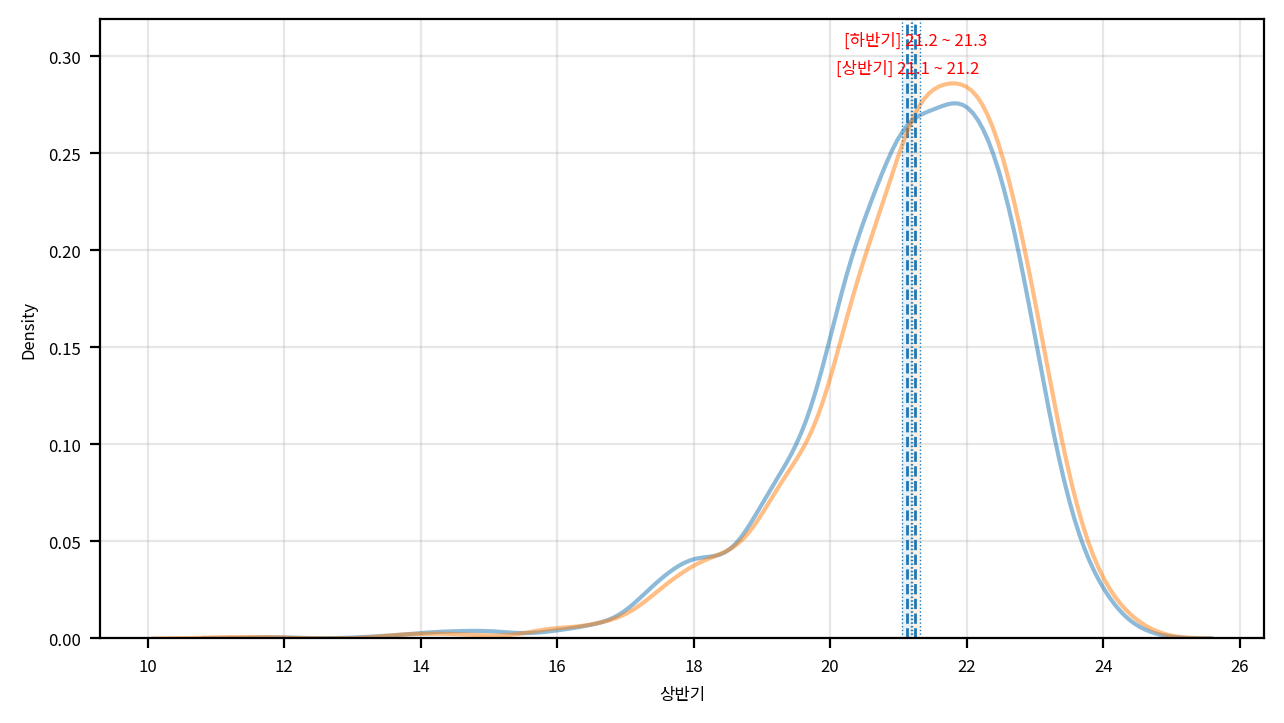

,statistic,p-value,result
field,,,
상반기,400.830692,9.135265e-88,False
하반기,459.342720,1.798853e-100,False


In [67]:
data = df6[['상반기', '하반기']] # 확인할 데이터
# ---------------------------------
# 데이터 분포 / 신뢰구간 시각화
# ---------------------------------
# 1) 그래프 초기화
width_px = 1280 # 그래프 가로 크기
height_px = 720 # 그래프 세로 크기
rows = 1 # 그래프 행 수
cols = 1 # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)
for c in data.columns:
    # KDE Plot 그리기
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)
    # 신뢰구간
    max = data[c].max() # 최대값
    clevel = 0.95 # 신뢰수준
    dof = len(data[c]) - 1 # 자유도
    sp_mean = data[c].mean() # 표본평균
    sp_std = data[c].std(ddof=1) # 표본표준편차
    sp_std_error = sp_std / sqrt(len(data[c])) # 표본표준오차
    cmin, cmax = t.interval(clevel, dof, loc=sp_mean,   
        scale=sp_std_error)
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)
    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)
    # 텍스트 그리기
    ax.text(x=(cmax-cmin)/2+cmin,
    y=ymax,
    s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"})
    # 3) 그래프 꾸미기
ax.grid(True, alpha=0.3) # 배경 격자 표시/숨김
# 4) 출력
plt.tight_layout() # 여백 제거
plt.show() # 그래프 화면 출력
plt.close() # 그래프 작업 종료
# ----------------------------------
# 가설검정의 가정 확인
# ----------------------------------
equal_var_fields = []
normal_dist = True
report = []
for c in data.columns:
    s, p = normaltest(data[c])
    normalize = p > 0.05
    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })
normal_dist = normal_dist and normalize
report_df = DataFrame(report).set_index('field')
report_df

In [75]:
fields = ['상반기', '하반기'] # 검정할 데이터 필드명
use_log = False # 로그 적용 여부
equal_var = True # 등분산성 충족 여부
df = df5[fields] # 검정할 데이터
alternative = ["two-sided", "less", "greater"] # 검사할 알고리즘
result = [] # 결과를 저장할 빈 리스트
fmt = "μ({f0}) {0} μ({f1})" # 가설식 템플릿
for a in alternative:
    input1 = df[fields[0]]
    input2 = df[fields[1]]
    s, p = wilcoxon(input1, input2, alternative=a)
    itp = None
    if a == "two-sided":
        itp = fmt.format("==" if p > 0.05 else "/=", f0=fields[0],
        f1=fields[1])
    elif a == "less":
        itp = fmt.format(">=" if p > 0.05 else "<", f0=fields[0],
        f1=fields[1])
    else:
        itp = fmt.format("<=" if p > 0.05 else ">", f0=fields[0],
        f1=fields[1])
    result.append({
        "alternative": a, # 검정의 의미
        "statistic": s, # 통계량
        "p-value": p, # 유의수준
        "H0": p > 0.05, # 귀무가설 채택 여부
        "H1": p <= 0.05, # 대립가설 채택 여부
        "interpretation": itp # 해석 결과
    })
# 두 집단의 평균이 같다고 판정되면 이후 less, greater는 무의미하므로 중단
    if a == "two-sided" and p > 0.05:
        break
rdf = DataFrame(result)
rdf.set_index("alternative", inplace=True)
rdf

,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,898435.0,4.824982e-08,False,True,μ(상반기) /= μ(하반기)
less,898435.0,2.412491e-08,False,True,μ(상반기) < μ(하반기)
greater,898435.0,1.000000e+00,True,False,μ(상반기) <= μ(하반기)
